In [626]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

from sklearn.linear_model import LogisticRegression as LR

In [627]:
dems = pd.read_csv('../datasets/dem_candidates.csv')
fec_house = pd.read_csv('../datasets/fec-house.csv')
fec_senate = pd.read_csv('../datasets/fec-senate.csv')
fec = pd.concat([fec_house, fec_senate], ignore_index=True)

In [628]:
def count_candidates_by_district(df, district_column, new_column_name):
    """
    Adds a column to the DataFrame with the count of candidates in each district.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the candidates and districts.
    district_column (str): The name of the column with district information.
    new_column_name (str): The name of the new column to hold the counts.

    Returns:
    pd.DataFrame: The original DataFrame with an additional column for candidate counts per district.
    """
    # Calculate the number of candidates in each district
    district_counts = df.groupby(district_column).size().reset_index(name=new_column_name)
    
    # Merge the counts back into the original DataFrame
    df_merged = df.merge(district_counts, on=district_column)

    return df_merged

In [629]:
dems = count_candidates_by_district(dems, 'District', 'total_runners') #run the above func to get count of ppl in each race and add that as a new col
dems = dems[dems['total_runners'] > 1] # filter out all the rows where only 1 person ran. 
dems = dems[dems['Race Type'] == 'Regular'] # filter out all special races due to repetitions and different circumstances
dems = dems[dems['Office Type'] == 'Representative'] #just house

dems = dems.rename(columns={'Warren Endorsed? ': 'Warren Endorsed?', 'Guns Sense Candidate?': 'Gun Sense Candidate?'})
endorsement_cols = dems.columns[pd.Series(dems.columns).str.contains('Endorsed')].values
endorsement_cols = np.append(endorsement_cols, 'Gun Sense Candidate?')
endorsement_cols = np.append(endorsement_cols, 'Party Support?')
# endorsement_cols = np.append(endorsement_cols, 'No Labels Support?')
dems[endorsement_cols] = dems[endorsement_cols].replace({'No': 0, 'Yes': 1})
dems['Total Endorsements'] = dems[endorsement_cols].sum(axis=1)
dems['Endorsed'] = (dems['Total Endorsements'] > 0).astype(int)

dems['Won Primary'] = (dems['Won Primary'] == 'Yes').astype(int)
dems['Primary Status'] = (dems['Primary Status'] == 'Advanced').astype(int) # same as Won Primary but no missing values

dems['Race'] = (dems['Race'] == 'Nonwhite').astype(int)
dems['Veteran?'] = (dems['Veteran?'] == 'Yes').astype(int)
dems['LGBTQ?'] = (dems['LGBTQ?'] == 'Yes').astype(int)
dems['Self-Funder?'] = (dems['Self-Funder?'] == 'Yes').astype(int)
dems['STEM?'] = (dems['STEM?'] == 'Yes').astype(int)
dems['Elected Official?'] = (dems['Elected Official?'] == 'Yes').astype(int)

dems = dems.reset_index().drop(columns=['index'])

In [630]:
dems.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,total_runners,Total Endorsements,Endorsed
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,0,None,None,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,0
1,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,1,None,On the Ballot,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,0
2,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,0,None,None,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,0
3,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,1,None,On the Ballot,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0,0
4,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,0,None,None,-33.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,1


In [631]:
dems.columns

Index(['Candidate', 'State', 'District', 'Office Type', 'Race Type',
       'Race Primary Election Date', 'Primary Status', 'Primary Runoff Status',
       'General Status', 'Partisan Lean', 'Primary %', 'Won Primary', 'Race',
       'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Gun Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed?',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'total_runners', 'Total Endorsements', 'Endorsed'],
      dtype='object')

Justice Dems (50), Our Revolution (85), WFP (30), Indivisible (46), VoteVets (28), Emily (54), PCCC (15), Party (39), Gun Sense (193)

In [632]:
endorsement_cols

array(['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed?',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'Gun Sense Candidate?', 'Party Support?'], dtype=object)

In [633]:
fec.head()

,name,office,office_full,party,party_full,state,district,district_number,election_districts,election_years,...,party.1,office.1,candidate_inactive.1,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,state.1,district.1,district_number.1,state_full
0,"SEWELL, TERRI A.",H,House,DEM,DEMOCRATIC PARTY,AL,7,7,"{07,07,07,07,07,07,07,07}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,314433.51,0.00,1453045.73,AL,7,7,Alabama
1,"BERA, AMERISH",H,House,DEM,DEMOCRATIC PARTY,CA,7,7,"{03,07,07,07,07,07,06,06}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,1463699.25,0.00,1193555.00,CA,7,7,California
2,"DESAULNIER, MARK",H,House,DEM,DEMOCRATIC PARTY,CA,11,11,"{10,11,11,11,11,10,10}","{2010,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,177938.55,0.00,344100.00,CA,11,11,California
3,"GARAMENDI, JOHN",H,House,DEM,DEMOCRATIC PARTY,CA,3,3,"{10,03,03,03,03,03,08,08}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,346985.92,0.00,712960.30,CA,3,3,California
4,"SCHIFF, ADAM",H,House,DEM,DEMOCRATIC PARTY,CA,28,28,"{27,29,29,29,29,29,28,28,28,28,28,30,30}","{2000,2002,2004,2006,2008,2010,2012,2014,2016,...",...,DEM,H,f,2955743.08,722929.86,566750.00,CA,28,28,California


In [634]:
fec.columns

Index(['name', 'office', 'office_full', 'party', 'party_full', 'state',
       'district', 'district_number', 'election_districts', 'election_years',
       'cycles', 'candidate_status', 'incumbent_challenge',
       'incumbent_challenge_full', 'load_date', 'first_file_date',
       'last_file_date', 'last_f2_date', 'candidate_id', 'two_year_period',
       'candidate_election_year', 'address_city', 'address_state',
       'address_street_1', 'address_street_2', 'address_zip',
       'candidate_inactive', 'active_through', 'candidate_id.1',
       'election_year', 'cycle', 'is_election', 'receipts', 'disbursements',
       'cash_on_hand_end_period', 'debts_owed_by_committee',
       'coverage_start_date', 'coverage_end_date', 'federal_funds_flag',
       'has_raised_funds', 'party.1', 'office.1', 'candidate_inactive.1',
       'individual_itemized_contributions',
       'transfers_from_other_authorized_committee',
       'other_political_committee_contributions', 'state.1', 'district.1

In [635]:
test = fec['name'].str.lower().str.extract(', (\w+\s*\w*)')
test

,0
0,terri a
1,amerish
2,mark
3,john
4,adam
...,...
1650,james courage
1651,jenny
1652,mitchell kent
1653,maria


In [636]:
r = '({})'.format('|'.join(test[0]))
r
#merge_df = df2.Domain.str.extract(r, expand=False).fillna(df2.Domain)

TypeError: sequence item 808: expected str instance, float found

In [563]:
fec[fec['last'] == 'scholten']

,name,office,office_full,party,party_full,state,district,district_number,election_districts,election_years,...,candidate_inactive.1,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,state.1,district.1,district_number.1,state_full,first,last
660,"SCHOLTEN, JAMES D.",H,House,DEM,DEMOCRATIC PARTY,IA,4,4,"{04,04}","{2018,2020}",...,f,1522305.83,18061.52,188827.01,IA,4,4,Iowa,james,scholten


In [637]:
dems['first'] = dems['Candidate'].str.lower().str.split(' ', n=1, expand=True)[0]
lastnames = dems['Candidate'].str.lower().str.split(' ', n=1, expand=True)[1].str.findall('^([a-z]*)$|(?<=[\s\t])(\w+\-*)$|^(\w+\-*)(?=[\s\t])').str[-1].astype(str).str.extract('(\w+)')
dems['last'] = lastnames[0]

fec['first'] = fec['name'].str.lower().str.extract(', (\w+)')[0]
fec['last'] = fec['name'].str.lower().str.extract('(\w+\s*)')[0]

merged = pd.merge(dems, fec, how='left', left_on=['first', 'last'], right_on=['first', 'last']).drop(columns=['office_full', 'party', 'party_full', 'state', 'district',
       'district_number', 'election_districts', 'election_years', 'cycles', 
       'candidate_status', 'incumbent_challenge', 'incumbent_challenge_full',
       'load_date', 'address_city', 'first_file_date', 'last_file_date', 'last_f2_date', 
       'candidate_id', 'two_year_period', 'candidate_election_year', 'address_state', 
       'address_street_1', 'address_street_2', 'candidate_inactive', 'active_through', 
       'candidate_id.1', 'election_year', 'cycle', 'is_election',  
       'federal_funds_flag', 'has_raised_funds', 'party.1', 'office.1', 'candidate_inactive.1', 'state.1', 'district.1', 'district_number.1', 'state_full'])
merged = merged[merged['Office Type'] == 'Representative']
merged[merged['name'].isna()][['Candidate', 'State', 'District', 'first', 'last', 'name', 'office']].head(50)

,Candidate,State,District,first,last,name,office
7,Lee Auman,AL,U.S. House Alabama District 4,lee,auman,NaN,NaN
8,Rick Neighbors,AL,U.S. House Alabama District 4,rick,neighbors,NaN,NaN
9,Clarke Tucker,AR,U.S. House Arkansas District 2,clarke,tucker,NaN,NaN
10,Gwen Combs,AR,U.S. House Arkansas District 2,gwen,combs,NaN,NaN
16,Marty Walters,CA,U.S. House California District 1,marty,walters,NaN,NaN
17,Dotty Nygard,CA,U.S. House California District 10,dotty,nygard,NaN,NaN
20,Mike Barkley,CA,U.S. House California District 10,mike,barkley,NaN,NaN
32,Katie Hill,CA,U.S. House California District 25,katie,hill,NaN,NaN
35,Gil Cisneros,CA,U.S. House California District 39,gil,cisneros,NaN,NaN
38,Sam Jammal,CA,U.S. House California District 39,sam,jammal,NaN,NaN


## Inverse Propensity Weighting: Party Support
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Party Support?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [638]:
party = merged[merged['Party Support?'].notnull() == True][['Won Primary', 'Party Support?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index']).dropna()
party['Total Other Endorsements'] = party['Total Endorsements'] - party['Party Support?']
party = party.drop(columns=['Total Endorsements'])[party['receipts'].notnull()]
party.head()

,Won Primary,Party Support?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
2,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0
3,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0
5,1,1.0,0.62,0,0,0,1,0,8441529.09,1.0
6,0,0.0,0.62,0,0,0,0,0,346820.52,0.0
8,0,0.0,0.62,0,0,0,1,1,840266.61,0.0


In [639]:
# creating our treatment, outcome, and confounder arrays
Z = party['Party Support?'].values
Y = party['Won Primary'].values
X = party.drop(['Party Support?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.20034240604928077

In [641]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.911038961038961

### Adding the propensity scores

In [642]:
party['pscore'] = fit.predict_proba(X)[:, 1]
party.head()

,Won Primary,Party Support?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
2,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0,0.501471
3,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0,0.511522
5,1,1.0,0.62,0,0,0,1,0,8441529.09,1.0,0.808567
6,0,0.0,0.62,0,0,0,0,0,346820.52,0.0,0.514794
8,0,0.0,0.62,0,0,0,1,1,840266.61,0.0,0.535791


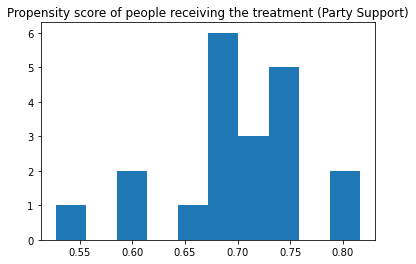

In [643]:
plt.hist(party[party['Party Support?'] == 1]['pscore']);
plt.title("Propensity score of people receiving the treatment (Party Support)")
plt.savefig('party_support_treat.png');

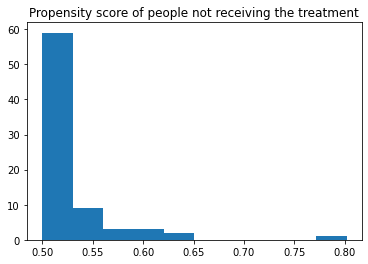

In [645]:
plt.hist(party[party['Party Support?'] == 0]['pscore']);
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('party_support_ctrl.png');

### IPW Estimate

In [579]:
reweighted_treated = (party[party['Party Support?'] == 1]['Won Primary'] / party[party['Party Support?'] == 1]['pscore']).sum()
reweighted_control = (party[party['Party Support?'] == 0]['Won Primary'] / (1 - party[party['Party Support?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(party)
print('IPW estimate:', ipw_estimate)

obs_filt = party[party['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Party Support?'] == 1]['Won Primary'] / obs_filt[obs_filt['Party Support?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Party Support?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Party Support?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.20034240604928075
trimmed IPW estimate: 0.20034240604928075


## Inverse Propensity Weighting: Our Revolution
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Our Revolution Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [646]:
our_rev = merged[merged['Our Revolution Endorsed?'].notnull() == True][['Won Primary', 'Our Revolution Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index']).dropna()
our_rev['Total Other Endorsements'] = our_rev['Total Endorsements'] - our_rev['Our Revolution Endorsed?']
our_rev = our_rev.drop(columns=['Total Endorsements'])[our_rev['receipts'].notnull()]
our_rev.head()

,Won Primary,Our Revolution Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0
5,1,0.0,0.620000,0,0,0,1,0,8441529.09,2.0
6,0,0.0,0.620000,0,0,0,0,0,346820.52,0.0


In [647]:
# creating our treatment, outcome, and confounder arrays
Z = our_rev['Our Revolution Endorsed?'].values
Y = our_rev['Won Primary'].values
X = our_rev.drop(['Our Revolution Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

# function for estimating treatment effect
def estimate_treatment_effect(model, X, Y, Z):
    return np.mean((Z * Y / model.predict_proba(X)[:, 1]) - ((1 - Z) * Y / model.predict_proba(X)[:, 0]))

estimate_treatment_effect(fit, X, Y, Z)

0.01594693261788031

Since this is a negative number, the treatment (being endorsed by `Our Revolution`) caused the probability of winning to decrease.

In [648]:
# naive estimator from HW4, not sure if we need for this
# the naive estimator does not account for confounders!
# Interesting... once we control for confounders, we observe the opposite effect (positive to negative)
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.07342211928199188

### Adding the propensity scores

In [649]:
our_rev['pscore'] = fit.predict_proba(X)[:, 1]
our_rev.head()

,Won Primary,Our Revolution Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0,0.316299
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0,0.496967
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0,0.449255
5,1,0.0,0.620000,0,0,0,1,0,8441529.09,2.0,0.002655
6,0,0.0,0.620000,0,0,0,0,0,346820.52,0.0,0.439406


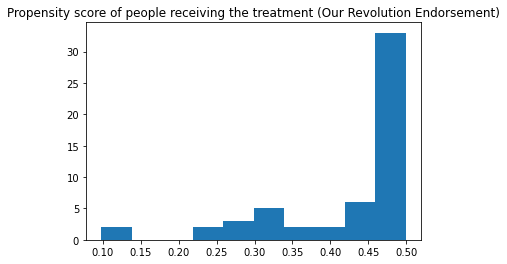

In [650]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment (Our Revolution Endorsement)")
plt.savefig('our_rev_treat.png');

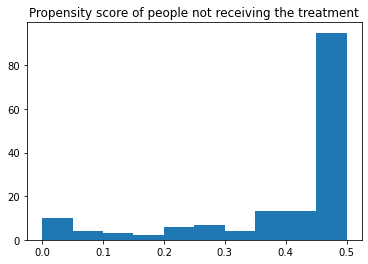

In [651]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('our_rev_ctrl.png');

### IPW Estimate

In [620]:
reweighted_treated = (our_rev[our_rev['Our Revolution Endorsed?'] == 1]['Won Primary'] / our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (our_rev[our_rev['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(our_rev)
print('IPW estimate:', ipw_estimate)

obs_filt = our_rev[our_rev['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.015946932617880254
trimmed IPW estimate: 0.0904672520911491


## Inverse Propensity Weighting: Emily's List
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Emily Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [652]:
emily = merged[merged['Emily Endorsed?'].notnull() == True][['Won Primary', 'Emily Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
emily['Total Other Endorsements'] = emily['Total Endorsements'] - emily['Emily Endorsed?']
emily = emily.drop(columns=['Total Endorsements'])[emily['receipts'].notnull()]
emily.head()

,Won Primary,Emily Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
1,1,0.0,0.62,0,0,0,1,0,8441529.09,2.0
2,0,0.0,0.62,0,0,0,0,0,346820.52,0.0
4,0,0.0,0.62,0,0,0,1,1,840266.61,0.0
5,0,1.0,0.62,1,0,0,0,1,355454.26,2.0
6,0,0.0,2.02,0,0,0,0,0,1217418.32,2.0


In [653]:
# creating our treatment, outcome, and confounder arrays
Z = emily['Emily Endorsed?'].values
Y = emily['Won Primary'].values
X = emily.drop(['Emily Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.18413335460197022

In [654]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.5661599099099099

### Adding the propensity scores

In [655]:
emily['pscore'] = fit.predict_proba(X)[:, 1]
emily.head()

,Won Primary,Emily Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
1,1,0.0,0.62,0,0,0,1,0,8441529.09,2.0,0.441216
2,0,0.0,0.62,0,0,0,0,0,346820.52,0.0,0.497574
4,0,0.0,0.62,0,0,0,1,1,840266.61,0.0,0.494122
5,0,1.0,0.62,1,0,0,0,1,355454.26,2.0,0.497513
6,0,0.0,2.02,0,0,0,0,0,1217418.32,2.0,0.491484


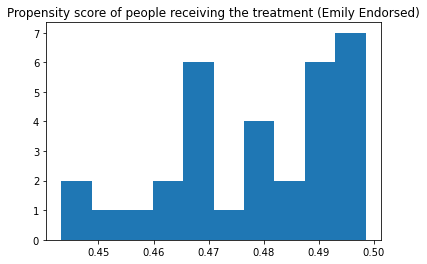

In [656]:
plt.hist(emily[emily['Emily Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment (Emily Endorsed)")
plt.savefig('emily_treat.png');

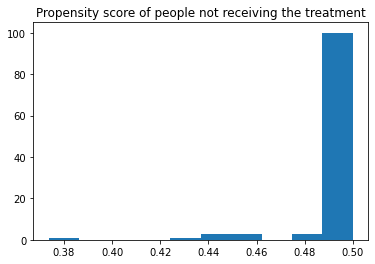

In [657]:
plt.hist(emily[emily['Emily Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('emily_ctrl.png');

### IPW Estimate

In [590]:
reweighted_treated = (emily[emily['Emily Endorsed?'] == 1]['Won Primary'] / emily[emily['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (emily[emily['Emily Endorsed?'] == 0]['Won Primary'] / (1 - emily[emily['Emily Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(emily)
print('IPW estimate:', ipw_estimate)

obs_filt = emily[emily['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Emily Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.18413335460197025
trimmed IPW estimate: 0.18413335460197025


## Inverse Propensity Weighting: Justice Dems
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Justice Dems Endorsed?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [658]:
jd = merged[merged['Justice Dems Endorsed?'].notnull() == True][['Won Primary', 'Justice Dems Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
jd['Total Other Endorsements'] = jd['Total Endorsements'] - jd['Justice Dems Endorsed?']
jd = jd.drop(columns=['Total Endorsements'])[jd['receipts'].notnull()]
jd.head()

,Won Primary,Justice Dems Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0
5,1,0.0,0.620000,0,0,0,1,0,8441529.09,2.0
6,0,0.0,0.620000,0,0,0,0,0,346820.52,0.0


In [659]:
# creating our treatment, outcome, and confounder arrays
Z = jd['Justice Dems Endorsed?'].values
Y = jd['Won Primary'].values
X = jd.drop(['Justice Dems Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.05890540908009506

In [660]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.02885682574916759

### Adding the propensity scores

In [661]:
jd['pscore'] = fit.predict_proba(X)[:, 1]
jd.head()

,Won Primary,Justice Dems Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0,0.270612
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0,0.496099
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0,0.434874
5,1,0.0,0.620000,0,0,0,1,0,8441529.09,2.0,0.000487
6,0,0.0,0.620000,0,0,0,0,0,346820.52,0.0,0.422308


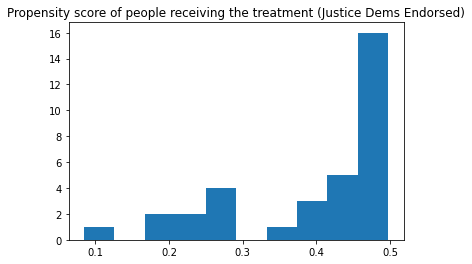

In [662]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment (Justice Dems Endorsed)")
plt.savefig('justice_dems_treat.png');

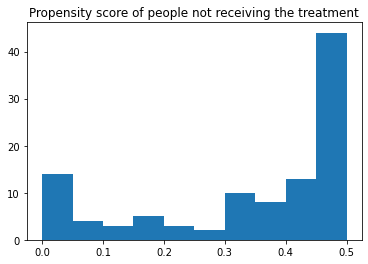

In [663]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('justice_dems_ctrl.png');

### IPW Estimate

In [605]:
reweighted_treated = (jd[jd['Justice Dems Endorsed?'] == 1]['Won Primary'] / jd[jd['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (jd[jd['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(jd)
print('IPW estimate:', ipw_estimate)

obs_filt = jd[jd['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.05890540908009511
trimmed IPW estimate: 0.1062207810625382


## Inverse Propensity Weighting: Gun Sense
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Gun Sense Candidate?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [664]:
gs = merged[merged['Gun Sense Candidate?'].notnull() == True][['Won Primary', 'Gun Sense Candidate?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
gs['Total Other Endorsements'] = gs['Total Endorsements'] - gs['Gun Sense Candidate?']
gs = gs.drop(columns=['Total Endorsements'])[gs['receipts'].notnull()]
gs.head()

,Won Primary,Gun Sense Candidate?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,0,1.0,-33.66,1,0,0,1,0,14535.25,0.0
1,1,1.0,-33.66,0,0,0,0,0,467514.71,0.0
6,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0
7,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0
9,1,1.0,0.62,0,0,0,1,0,8441529.09,1.0


In [665]:
# creating our treatment, outcome, and confounder arrays
Z = gs['Gun Sense Candidate?'].values
Y = gs['Won Primary'].values
X = gs.drop(['Gun Sense Candidate?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.11783925876002786

In [666]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.3112010796221323

### Adding the propensity scores


In [667]:
gs['pscore'] = fit.predict_proba(X)[:, 1]
gs.head()

,Won Primary,Gun Sense Candidate?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,0,1.0,-33.66,1,0,0,1,0,14535.25,0.0,0.501530
1,1,1.0,-33.66,0,0,0,0,0,467514.71,0.0,0.549054
6,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0,0.503628
7,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0,0.528400
9,1,1.0,0.62,0,0,0,1,0,8441529.09,1.0,0.972195


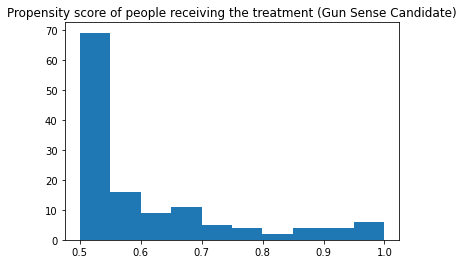

In [668]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment (Gun Sense Candidate)")
plt.savefig('gun_sense_treat.png');

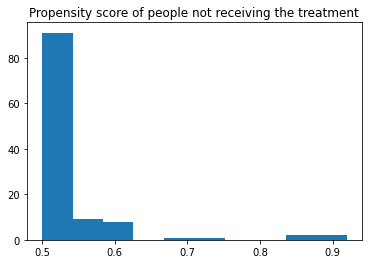

In [669]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('gun_sense_ctrl.png');

### IPW Estimate

In [613]:
reweighted_treated = (gs[gs['Gun Sense Candidate?'] == 1]['Won Primary'] / gs[gs['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control = (gs[gs['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - gs[gs['Gun Sense Candidate?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(gs)
print('IPW estimate:', ipw_estimate)

obs_filt = gs[gs['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['Won Primary'] / obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.11783925876002785
trimmed IPW estimate: 0.1317072027109781


## Bootstrapping ATE estimates

In [ ]:
#TODO: Fill in the missing values
def draw_tau_hat(data=obs, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(frac=1, replace=True, random_state=random_state)
    fit_model = fit_OLS_model(sample, 'outcome', ['treat', 'age', 'educ', 'black', 'hisp', 'marr', 'nodegree'])
    estimated_ate = fit_model.params['treat']
    return estimated_ate

def get_bootstrapped_ate(data=obs, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data))
    return estimates